In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES = 3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import os
import pickle as pkl
import cv2 
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim 


from models import FCN

from utils import train_procedure, AdeDataset, get_ade_transforms, load_model

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
%autoreload 2

In [3]:
SAVES_PATH = "saves"
BATCH_SIZE = 12
device = torch.device('cuda')

In [4]:
transform = get_ade_transforms(resize=512)
train_dataset = AdeDataset(transform=transform, mode='training')
val_dataset = AdeDataset(transform=transform, mode='validation')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

In [7]:
if 'model' in locals():
    del model
    
N_EPOCHS = 20
RESUME_TRAINING = False

model_name = 'fcn_nobug'
epoch = 0

model = FCN(num_classes=151, k_factor=12, num_units_collection=(3, 6, 12, 8), pretrained=True, 
           ckpt_path=f'saves/ckpts3/densenet_staged_model.pt')
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

if RESUME_TRAINING:
    epoch = load_model(model, optimizer=optimizer, device=device, ckpt_path=os.path.join(SAVES_PATH, f'ckpts3/{model_name}_model.pt'))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, min_lr=1e-8)
model.to(device);

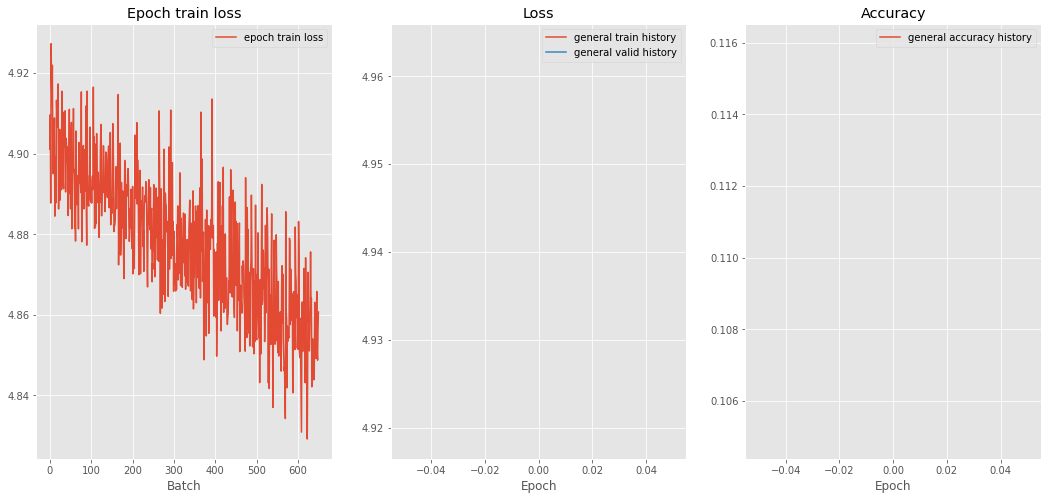

In [ ]:
train_procedure(n_epochs=N_EPOCHS, model=model, train_iterator=train_dataloader, 
                val_iterator=val_dataloader, optimizer=optimizer,
                criterion=loss, saves_path=SAVES_PATH, start_epoch=epoch, 
                device=device, scheduler=scheduler, model_name=model_name,
               segmentation=True)

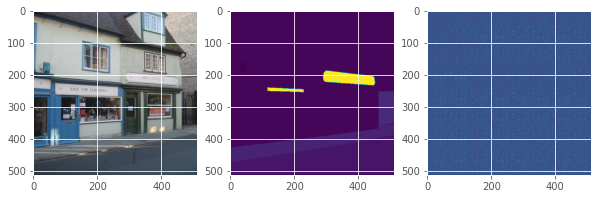

In [122]:
mean=[125, 119, 110]
std=[57, 57, 61]

renorm = T.Compose(
    [
    T.Normalize(mean=(0,0,0), std = 1. / np.array(std)),
    T.Normalize(mean=-np.array(mean), std=(1., 1., 1.)), 
    T.ToPILImage(mode='RGB')])

mask_transform = T.Compose(
    [ T.ToPILImage(mode='RGB')] )

imgs, targets = next(iter(val_dataloader))
img = imgs[0, ...]
trg = targets[0, ...]

model.eval()
with torch.no_grad():
    outputs = model(imgs.to(device))
    outputs = outputs.detach().cpu()
    out = outputs[0, ...].argmax(axis=0)

img.shape, trg.shape
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 15))
ax1.imshow(renorm(img))
ax2.imshow(trg)
ax3.imshow(out)